
================= INSTÂNCIA PEQUENA (10 itens) =================

PSO:
 Melhor: 364
 Médio : 364.00
 Pior  : 364
 Desvio-padrão: 0.00
 Tempo médio: 0.0643s

SA:
 Melhor: 364
 Médio : 339.68
 Pior  : 285
 Desvio-padrão: 26.76
 Tempo médio: 0.0116s

================= INSTÂNCIA MÉDIA (30 itens) =================

PSO:
 Melhor: 1101
 Médio : 1052.48
 Pior  : 1011
 Desvio-padrão: 17.92
 Tempo médio: 0.2032s

SA:
 Melhor: 1088
 Médio : 972.38
 Pior  : 636
 Desvio-padrão: 76.02
 Tempo médio: 0.0243s

================= INSTÂNCIA GRANDE (100 itens) =================

PSO:
 Melhor: 3326
 Médio : 3120.99
 Pior  : 2942
 Desvio-padrão: 65.37
 Tempo médio: 0.5397s

SA:
 Melhor: 3348
 Médio : 2654.33
 Pior  : 2094
 Desvio-padrão: 278.11
 Tempo médio: 0.0523s


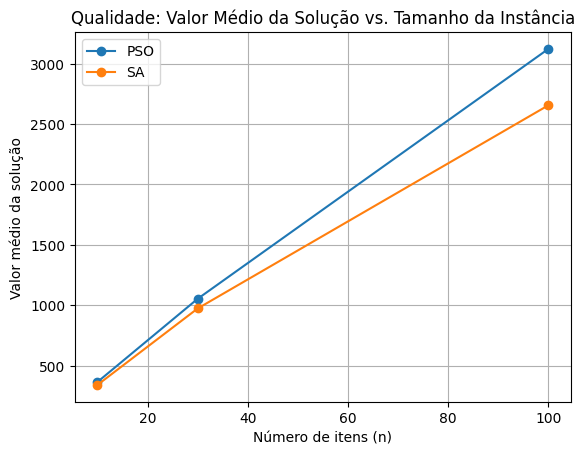

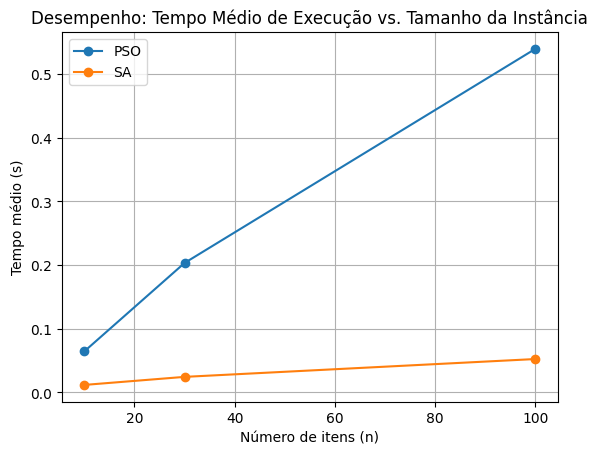

/tmp/ipython-input-3650954585.py:284: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados_boxplot, labels=rotulos_boxplot, showmeans=True)


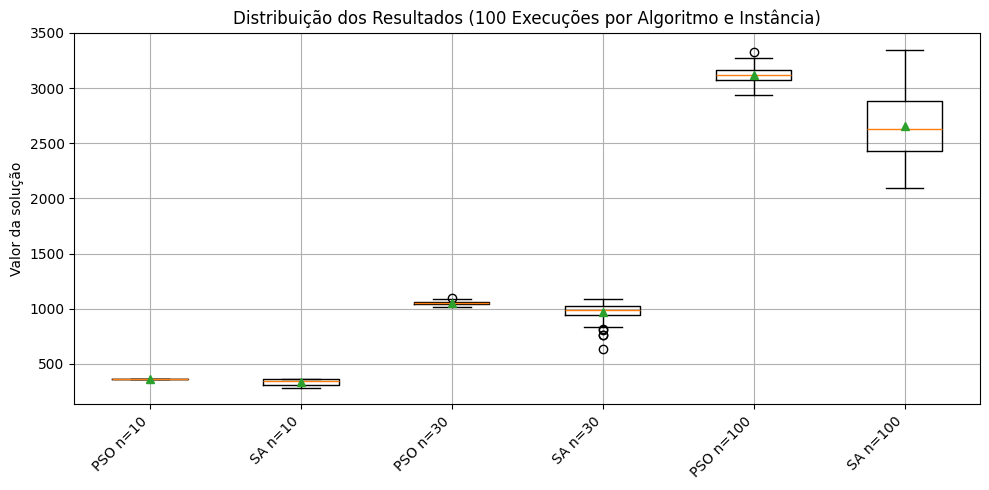

In [ ]:
import random
import math
import time
import statistics
import matplotlib.pyplot as plt

# Utilitários

def avaliar(solucao, pesos, valores, capacidade):
    """Calcula o valor total da solução e verifica a restrição de capacidade."""
    peso_total = sum(bit * p for bit, p in zip(solucao, pesos))
    valor_total = sum(bit * v for bit, v in zip(solucao, valores))
    # Retorna o valor se o peso estiver dentro da capacidade, caso contrário, retorna 0 (solução inválida)
    return valor_total if peso_total <= capacidade else 0

def solucao_aleatoria(n):
    """Gera uma solução binária aleatória de tamanho n."""
    return [random.randint(0, 1) for _ in range(n)]

def gerar_instancia(n_itens):
    """Gera pesos, valores e capacidade para o Problema da Mochila."""
    pesos = [random.randint(1, 50) for _ in range(n_itens)]
    valores = [random.randint(10, 100) for _ in range(n_itens)]
    # A capacidade é definida como 40% do peso total para criar um problema restrito.
    capacidade = int(sum(pesos) * 0.4)
    return pesos, valores, capacidade

# Otimização por Enxame de Partículas (PSO)

class OtimizacaoEnxameParticulas:
    def __init__(self, n_particulas, n_itens, pesos, valores, capacidade,
                 w=0.7, c1=1.5, c2=1.5, max_iter=200):

        self.n_particulas = n_particulas
        self.n_itens = n_itens
        self.pesos = pesos
        self.valores = valores
        self.capacidade = capacidade

        # Parâmetros do PSO
        self.w = w          # Inércia (Exploração global vs. exploração local)
        self.c1 = c1        # Fator Cognitivo (Atrativo em direção ao melhor pessoal)
        self.c2 = c2        # Fator Social (Atrativo em direção ao melhor global)
        self.max_iter = max_iter

        # Inicialização do Enxame
        self.posicoes = [solucao_aleatoria(n_itens) for _ in range(n_particulas)]
        # Velocidades são valores reais (contínuos)
        self.velocidades = [[random.uniform(-1, 1) for _ in range(n_itens)]
                            for _ in range(n_particulas)]

        # Inicializa Pbest (Melhor Pessoal)
        self.pbest = list(self.posicoes)
        self.pbest_valores = [avaliar(sol, pesos, valores, capacidade)
                              for sol in self.posicoes]

        # Inicializa Gbest (Melhor Global)
        idx = self.pbest_valores.index(max(self.pbest_valores))
        self.gbest = self.posicoes[idx]
        self.gbest_valor = self.pbest_valores[idx]

    def sigmoide(self, x):
        """Função sigmoide para mapear a velocidade contínua para probabilidade binária."""
        # A probabilidade de um item ser selecionado (1) aumenta com a magnitude da velocidade.
        return 1 / (1 + math.exp(-x))

    def atualizar_particula(self, i):
        """Atualiza a velocidade e a posição (solução) de uma partícula."""
        for j in range(self.n_itens):
            r1, r2 = random.random(), random.random()

            # Equação de atualização de velocidade: Inércia + Cognitivo + Social
            self.velocidades[i][j] = (
                self.w * self.velocidades[i][j] +
                self.c1 * r1 * (self.pbest[i][j] - self.posicoes[i][j]) +
                self.c2 * r2 * (self.gbest[j] - self.posicoes[i][j])
            )

            # Mapeia a velocidade para probabilidade (sigmoide) e decide a nova posição (binária)
            prob = self.sigmoide(self.velocidades[i][j])
            self.posicoes[i][j] = 1 if random.random() < prob else 0

    def rodar(self):
        """Executa o algoritmo PSO pelo número máximo de iterações."""
        for _ in range(self.max_iter):
            for i in range(self.n_particulas):
                self.atualizar_particula(i)
                fitness = avaliar(self.posicoes[i], self.pesos, self.valores, self.capacidade)

                # Atualiza Pbest (Melhor Pessoal)
                if fitness > self.pbest_valores[i]:
                    self.pbest[i] = list(self.posicoes[i])
                    self.pbest_valores[i] = fitness

            # Atualiza Gbest (Melhor Global)
            melhor_iteracao = max(self.pbest_valores)
            if melhor_iteracao > self.gbest_valor:
                idx = self.pbest_valores.index(melhor_iteracao)
                self.gbest_valor = melhor_iteracao
                self.gbest = self.pbest[idx]

        return self.gbest_valor

# Recozimento Simulado (Simulated Annealing - SA)

class RecozimentoSimulado:
    def __init__(self, n_itens, pesos, valores, capacidade,
                 T=100, alpha=0.99, max_iter=3000):

        self.n_itens = n_itens
        self.pesos = pesos
        self.valores = valores
        self.capacidade = capacidade
        self.T = T          # Temperatura inicial
        self.alpha = alpha  # Fator de resfriamento
        self.max_iter = max_iter # Número máximo de iterações

    def vizinho(self, sol):
        """Gera uma solução vizinha, invertendo um bit aleatório."""
        idx = random.randint(0, self.n_itens - 1)
        nova = sol[:]
        nova[idx] = 1 - nova[idx]  # Inverte 0 para 1 ou 1 para 0
        return nova

    def rodar(self):
        """Executa o algoritmo SA."""
        # Solução atual (Inicialização)
        atual = solucao_aleatoria(self.n_itens)
        valor_atual = avaliar(atual, self.pesos, self.valores, self.capacidade)
        # Melhor solução encontrada
        melhor = atual[:]
        melhor_valor = valor_atual

        # O SA executa por um número fixo de iterações enquanto a temperatura cai
        for _ in range(self.max_iter):
            # Gera um vizinho
            candidato = self.vizinho(atual)
            valor_candidato = avaliar(candidato, self.pesos, self.valores, self.capacidade)

            delta = valor_candidato - valor_atual  # Diferença de qualidade

            # Critério de Aceitação:
            # 1. Aceita se for melhor (delta > 0)
            # 2. Aceita com probabilidade se for pior (math.exp(delta / self.T))
            if delta > 0 or random.random() < math.exp(delta / self.T):
                atual = candidato
                valor_atual = valor_candidato

            # Atualiza o melhor global
            if valor_atual > melhor_valor:
                melhor_valor = valor_atual
                melhor = atual[:]

            # Resfriamento: a temperatura diminui
            self.T *= self.alpha

        return melhor_valor

# Execução de Experimentos

def rodar_experimentos(titulo, num_execucoes, pesos, valores, capacidade):
    """Executa ambos os algoritmos e coleta resultados de valor e tempo."""
    n_itens = len(pesos)

    print(f"\n================= {titulo} =================")

    resultados_pso, resultados_sa = [], []
    tempos_pso, tempos_sa = [], []

    for _ in range(num_execucoes):
        # Execução PSO
        inicio = time.time()
        pso = OtimizacaoEnxameParticulas(30, n_itens, pesos, valores, capacidade)
        resultados_pso.append(pso.rodar())
        tempos_pso.append(time.time() - inicio)

        # Execução SA
        inicio = time.time()
        sa = RecozimentoSimulado(n_itens, pesos, valores, capacidade)
        resultados_sa.append(sa.rodar())
        tempos_sa.append(time.time() - inicio)

    # Imprime estatísticas de desempenho para PSO
    print("\nPSO:")
    print(f" Melhor: {max(resultados_pso)}")
    print(f" Médio : {statistics.mean(resultados_pso):.2f}")
    print(f" Pior  : {min(resultados_pso)}")
    print(f" Desvio-padrão: {statistics.stdev(resultados_pso):.2f}")
    print(f" Tempo médio: {statistics.mean(tempos_pso):.4f}s")

    # Imprime estatísticas de desempenho para SA
    print("\nSA:")
    print(f" Melhor: {max(resultados_sa)}")
    print(f" Médio : {statistics.mean(resultados_sa):.2f}")
    print(f" Pior  : {min(resultados_sa)}")
    print(f" Desvio-padrão: {statistics.stdev(resultados_sa):.2f}")
    print(f" Tempo médio: {statistics.mean(tempos_sa):.4f}s")

    return {
        "titulo": titulo,
        "n_itens": n_itens,
        "resultados_pso": resultados_pso,
        "resultados_sa": resultados_sa,
        "tempos_pso": tempos_pso,
        "tempos_sa": tempos_sa
    }

# Rodar instâncias + gerar gráficos

todos_resultados = []
NUM_EXECUCOES = 100 # Número de vezes que cada algoritmo roda por instância

# Pequena (10 itens)
pesos_p, valores_p, cap_p = gerar_instancia(10)
todos_resultados.append(rodar_experimentos("INSTÂNCIA PEQUENA (10 itens)", NUM_EXECUCOES, pesos_p, valores_p, cap_p))

# Média (30 itens)
pesos_m, valores_m, cap_m = gerar_instancia(30)
todos_resultados.append(rodar_experimentos("INSTÂNCIA MÉDIA (30 itens)", NUM_EXECUCOES, pesos_m, valores_m, cap_m))

# Grande (100 itens)
pesos_g, valores_g, cap_g = gerar_instancia(100)
todos_resultados.append(rodar_experimentos("INSTÂNCIA GRANDE (100 itens)", NUM_EXECUCOES, pesos_g, valores_g, cap_g))

#-------------------#
# GRÁFICOS (Gráficos)
#-------------------#

# Ordena os resultados pelo número de itens (n) para os gráficos de linha
todos_resultados = sorted(todos_resultados, key=lambda d: d["n_itens"])
ns = [r["n_itens"] for r in todos_resultados]

# Prepara dados para Gráfico (1): Qualidade
media_valores_pso = [statistics.mean(r["resultados_pso"]) for r in todos_resultados]
media_valores_sa  = [statistics.mean(r["resultados_sa"])  for r in todos_resultados]

# Prepara dados para Gráfico (2): Tempo
media_tempos_pso = [statistics.mean(r["tempos_pso"]) for r in todos_resultados]
media_tempos_sa  = [statistics.mean(r["tempos_sa"])  for r in todos_resultados]

# (1) Valor médio vs tamanho
plt.figure()
plt.plot(ns, media_valores_pso, marker="o", label="PSO")
plt.plot(ns, media_valores_sa, marker="o", label="SA")
plt.xlabel("Número de itens (n)")
plt.ylabel("Valor médio da solução")
plt.title("Qualidade: Valor Médio da Solução vs. Tamanho da Instância")
plt.grid(True)
plt.legend()
plt.show()

# (2) Tempo médio vs tamanho
plt.figure()
plt.plot(ns, media_tempos_pso, marker="o", label="PSO")
plt.plot(ns, media_tempos_sa, marker="o", label="SA")
plt.xlabel("Número de itens (n)")
plt.ylabel("Tempo médio (s)")
plt.title("Desempenho: Tempo Médio de Execução vs. Tamanho da Instância")
plt.grid(True)
plt.legend()
plt.show()

# (3) Boxplot (distribuição)
plt.figure(figsize=(10, 5))
dados_boxplot = []
rotulos_boxplot = []
for r in todos_resultados:
    # Adiciona os resultados do PSO e do SA para cada tamanho de instância
    dados_boxplot.append(r["resultados_pso"]); rotulos_boxplot.append(f"PSO n={r['n_itens']}")
    dados_boxplot.append(r["resultados_sa"]);  rotulos_boxplot.append(f"SA n={r['n_itens']}")

# Exibe o boxplot com a média
plt.boxplot(dados_boxplot, labels=rotulos_boxplot, showmeans=True)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Valor da solução")
plt.title("Distribuição dos Resultados (100 Execuções por Algoritmo e Instância)")
plt.grid(True)
plt.tight_layout()
plt.show()